## Sci-kit dataset preparation as matrix

This notebook shows how to prepare the datasets for sci-kit based models. Sci-kit's API is very consistent, and it should work "out of the box" when given numeric (2D) matrices.

In [15]:
!pip install -q seaborn molfeat


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [16]:
from typing import Literal, Union, Dict

import seaborn as sns
import pandas as pd
from pathlib import Path
from humps import camel
from pydantic import BaseModel
import numpy as np
import sklearn.base

from fleet.base_schemas import BaseModelFunctions
from fleet.model_builder.utils import get_references_dict
from fleet.dataset_schemas import DatasetConfigBuilder, DatasetConfig
from fleet import data_types
from fleet.utils import data
from fleet.yaml_model import YAML_Model
from fleet.model_builder.utils import get_class_from_path_string
from fleet.model_builder import splitters

### Loading the dataset

In [17]:
! [ ! -f HIV.csv ] && wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv
! [ ! -f SAMPL.csv ] && wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv

In [18]:
hiv_df = pd.read_csv('HIV.csv')
sampl_df = pd.read_csv('SAMPL.csv')

if 'step' not in hiv_df.columns:
    splitters.apply_split_indexes(
        hiv_df,
        split_type="scaffold",
        split_column="smiles",
        split_target="80-10-10")
    hiv_df.to_csv('HIV.csv', index=False)

if 'step' not in sampl_df.columns:
    splitters.apply_split_indexes(
        sampl_df,
        split_type="scaffold",
        split_column="smiles",
        split_target="80-10-10")
    sampl_df.to_csv('SAMPL.csv', index=False)


In [19]:
sampl_df

,iupac,smiles,expt,calc,step
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625,1
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219,1
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452,1
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809,3
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917,1
...,...,...,...,...,...
637,methyl octanoate,CCCCCCCC(=O)OC,-2.04,-3.035,1
638,pyrrolidine,C1CCNC1,-5.48,-4.278,3
639,4-hydroxybenzaldehyde,c1cc(ccc1C=O)O,-8.83,-10.050,1
640,1-chloroheptane,CCCCCCCCl,0.29,1.467,1


## Config Classes

First we need to create the interface to interact with sklearn classes and molfeat transforms.

To keep the same concepts from other parts of the app, we have 2 kinds of classes:

- `ConstructorArgs` classes: describe the arguments given to a class through it's constructor
- `Config` classes: describe the interaction with the class; `constructor_args` works as above explained, and `fit_args` models the arguments passed to the ML model class during fit.

In [20]:

class CamelCaseModel(BaseModel):
    """
    Subclass this class to work with camel case serialization of the model.
    """
    class Config:
        alias_generator = camel.case
        allow_population_by_field_name = True
        allow_population_by_alias = True
        underscore_attrs_are_private = True

class CreateFromType:
    """
    Adds a method to instantiate a class from it's class path (type) and constructor_args.
    
    Attributes:
        type (str): The class path of the class that will be instantiated.
        constructor_args (BaseModel): The constructor arguments passed to the class.
    """
    type: str
    constructor_args:  Union[None, BaseModel] = None
    
    def create(self):
        class_ = get_class_from_path_string(self.type)
        if self.constructor_args:
            return class_(**self.constructor_args.dict())
        return class_()

class FPVecFilteredTransformerConstructorArgs(BaseModel):
    """
    Models the constructor arguments of a FPVecFilteredTransformer.
    """
    del_invariant: bool = False
    length: int = 512
    
    
    
class FPVecFilteredTransformerConfig(CamelCaseModel, CreateFromType):
    """
    Models the usage of FPVecFilteredTransformer. 
    """
    name: str
    constructor_args: FPVecFilteredTransformerConstructorArgs = FPVecFilteredTransformerConstructorArgs()
    type = 'molfeat.trans.fp.FPVecFilteredTransformer'
    forward_args: dict
    
    
hiv_dataset_config = DatasetConfigBuilder('Test').with_features(
    smiles=data_types.SmileDataType(),
).with_targets(
    activity=data_types.CategoricalDataType(classes={'CI': 0, 'CM': 1, 'CA': 2})
).add_transforms(FPVecFilteredTransformerConfig(name="MolFPFeaturizer", forward_args={
    'X': '$smiles',
})).build()


hiv_dataset_config

DatasetConfig(name='Test', target_columns=[ColumnConfig(name='activity', data_type=CategoricalDataType(domain_kind='categorical', classes={'CI': 0, 'CM': 1, 'CA': 2}))], feature_columns=[ColumnConfig(name='smiles', data_type=SmileDataType(domain_kind='smiles'))], featurizers=[], transforms=[FPVecFilteredTransformerConfig(name='MolFPFeaturizer', constructor_args=FPVecFilteredTransformerConstructorArgs(del_invariant=False, length=512), forward_args={'X': '$smiles'}, type='molfeat.trans.fp.FPVecFilteredTransformer')])

In [21]:

class KNeighborsRegressorConstructorArgs(BaseModel):
    n_neighbors: int = 5
    algorithm: Literal['kd_tree'] = 'kd__tree'

class KNeighborsRegressorConfig(CamelCaseModel, CreateFromType):
    name: str
    type: Literal['sklearn.neighbors.KNeighborsRegressor'] = 'sklearn.neighbors.KNeighborstRegressor'
    constructor_args: KNeighborsRegressorConstructorArgs
    fit_args: Dict[str, str]
    
    
class RandomForestRegressorConstructorArgs(BaseModel):
    n_estimators: int = 50
    max_depth: Union[None, int] = None
    min_samples_split: Union[float, int] = 2
    min_samples_leaf: Union[float, int] = 1
    min_weight_fraction_leaf: float = .0
    max_features: Union[None, Literal['sqrt', 'log2']] = 1.
    max_leaf_nodes: Union[None, int] = None
    min_impurity_decrease: float = .0
    bootstrap: bool = True
    oob_score: bool = False
    n_jobs: Union[int, None] = None
    ccp_alpha: float = .0
    max_samples: Union[None, int, float] = None

class RandomForestRegressorConfig(CamelCaseModel, CreateFromType):
    type: Literal['sklearn.ensemble.RandomForestRegressor'] = 'sklearn.ensemble.RandomForestRegressor'
    constructor_args: RandomForestRegressorConstructorArgs = RandomForestRegressorConstructorArgs()
    fit_args: Dict[str, str]

class SklearnDatasetConfig(DatasetConfig):
    pass
    
class SklearnModelSchema(CamelCaseModel, YAML_Model):
    model: Union[KNeighborsRegressorConfig, RandomForestRegressorConfig]
    
class SklearnModelSpec(CamelCaseModel, YAML_Model):
    framework = 'sklearn'
    name: str
    dataset: SklearnDatasetConfig
    spec: SklearnModelSchema
    

We also create a class to operate the models with a dataset. Later this class can be improved to log different metrics depending on the model task.

In [38]:


class SklearnModelFunctions(BaseModelFunctions):
    
    model: Union[None, sklearn.base.RegressorMixin, sklearn.base.ClassifierMixin]
    
    def __init__(self, spec: SklearnModelSpec, dataset: pd.DataFrame):
        self.spec = spec
        self.dataset = dataset
    
    def _prepare_X_and_y(self, filter_step: Union[None, int] = None, targets=True):
        model_config = self.spec.spec
        dataset_config = self.spec.dataset
        
        if filter_step is not None:
            dataset = self.dataset[self.dataset['step'] == filter_step]
        
        references = get_references_dict(model_config.model.fit_args)
        args = { key: self.dataset[ref][:] for key, ref in references.items() }
        
        assert 'X' in args, 'sklearn models take an X argument'
        X = np.stack(args['X'].to_numpy())

        if targets:
            assert 'y' in args, 'sklearn models take an Y argument'
            y = args['y'].to_numpy()
            return X, y
        else:
            return X

        
    def train(self, *, params: BaseModel=None):
        model_config = self.spec.spec
        dataset_config = self.spec.dataset
        self.model = model_config.model.create()
        dataset = data.build_columns_numpy(
            dataset_config=dataset_config,
            df=self.dataset
        )
        X, y = self._prepare_X_and_y(filter_step=1)
        self.model.fit(X, y)
        
        
    def val(self):
        X, y = self._prepare_X_and_y(filter_step=2)
        if self.model is None:
            raise ValueError('sklearn model not trained')
        # coefficient of determination
        r2 = self.model.score(X, y)
        # TODO: get other metrics
        
        return r2
    
    def test(self):
        X, y = self._prepare_X_and_y(filter_step=3)
        if self.model is None:
            raise ValueError('sklearn model not trained')
        # coefficient of determination
        r2 = self.model.score(X, y)
        # TODO: get other metrics
        
        return r2
    
    def predict(self, X: pd.DataFrame):
        model_config = self.spec.spec
        dataset_config = self.spec.dataset
        dataset = data.build_columns_numpy(
            dataset_config=dataset_config,
            df=self.dataset
        )
        X = self._prepare_X_and_y(filter_step=1, targets=False)
        return self.model.predict(X)
        
        
        
    

In [39]:


# Creates a dataset config for SAMPL using DatasetConfigBuilder
sampl_dataset_config = DatasetConfigBuilder('SAMPL').with_features(
    smiles=data_types.SmileDataType(),
).with_targets(
    expt=data_types.NumericDataType()
).add_transforms(FPVecFilteredTransformerConfig(name="MolFPFeaturizer", forward_args={
    'X': '$smiles',
})).build()
    
# Creates a sklearn model config from yaml str
rf_regressor_config = SklearnModelSchema.from_yaml_str("""
model:
    type: sklearn.ensemble.RandomForestRegressor
    constructorArgs:
        n_estimators: 100
    fitArgs:
        X: $MolFPFeaturizer
        y: $expt
""")

sampl_regression_config = SklearnModelSpec(
    name="SAMPL Regressor",
    dataset=sampl_dataset_config,
    spec=rf_regressor_config
)
        

sampl_df = pd.read_csv('SAMPL.csv')

if 'step' not in sampl_df.columns:
    splitters.apply_split_indexes(
        sampl_df,
        split_type="scaffold",
        split_column="smiles",
        split_target="60-20-20")
    sampl_df.to_csv('SAMPL.csv', index=False)


sklearn_functions = SklearnModelFunctions(
    spec=sampl_regression_config,
    dataset=sampl_df
    
)
sklearn_functions.train()

In [40]:
sklearn_functions.val()

0.9546665496369807

In [41]:
sklearn_functions.test()

0.9546665496369807

<Axes: ylabel='expt'>

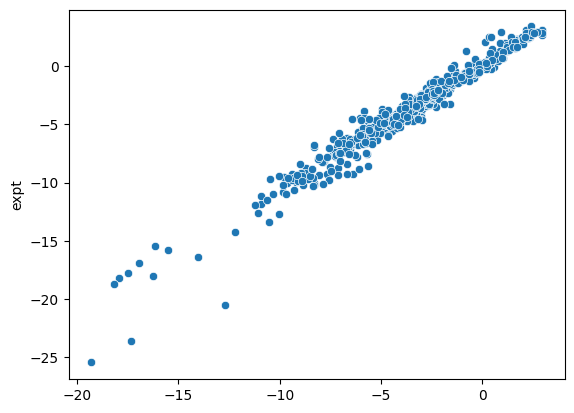

In [42]:
X_train = sampl_df
y_pred = sklearn_functions.predict(X_train)
sns.scatterplot(x = y_pred, y = sampl_df['expt'])